### Churn model - XGBoost

#### Imports

In [2]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
df = pd.read_csv('../database/processed/netflix_users_t100.csv')
df.head()

,Age,Subscription_Type,Watch_Time_Hours,Churn,Usage_Intensity,Is_Heavy_User,Age_Group,Country_Australia,Country_Brazil,Country_Canada,...,Country_Mexico,Country_UK,Country_USA,Favorite_Genre_Action,Favorite_Genre_Comedy,Favorite_Genre_Documentary,Favorite_Genre_Drama,Favorite_Genre_Horror,Favorite_Genre_Romance,Favorite_Genre_Sci-Fi
0,18,2,80.26,0,4.224211,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,23,2,321.75,0,13.406250,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,60,0,35.89,1,0.588361,0,3,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,44,2,261.56,0,5.812444,0,2,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,68,1,909.30,0,13.178261,1,3,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [6]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("churn-XGBoost")

X = df.drop(columns=['Churn', 'Subscription_Type'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        scale_pos_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="auc"
    ))
])

with mlflow.start_run(run_name="XGBoost-Pipeline-Final"):
    pipeline.fit(X_train, y_train.to_numpy())

    y_probs = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    
    auc_val = metrics.roc_auc_score(y_test, y_probs)
    recall_val = metrics.recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"ROC AUC: {auc_val:.4f}")
    
    mlflow.log_params(pipeline.named_steps['xgb'].get_params())
    mlflow.log_metric("roc_auc", auc_val)
    mlflow.log_metric("recall", recall_val)
    mlflow.log_metric("precision", precision)
    
    mlflow.sklearn.log_model(pipeline, "model_pipeline")

2025/12/21 00:32:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Precisão: 0.2545
Recall: 0.3768
ROC AUC: 0.5117
🏃 View run XGBoost-Pipeline-Final at: http://127.0.0.1:5000/#/experiments/5/runs/276317623237412db22c007608b879d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


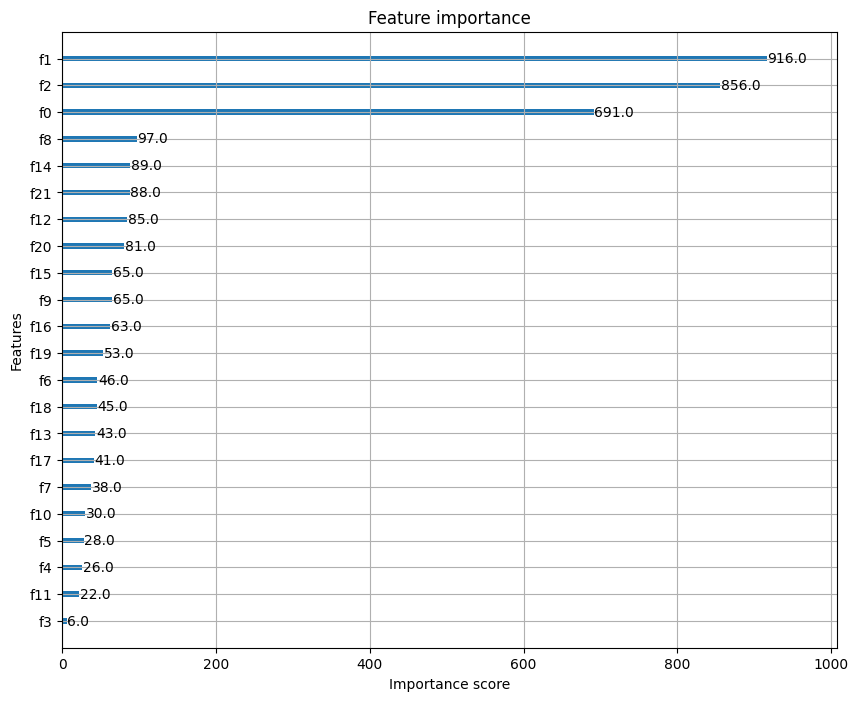

In [7]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(pipeline.named_steps['xgb'], ax=ax)
plt.show()